In [1]:
from __future__ import print_function
import re,string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import json
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity

# For biclustering
print(__doc__)
from collections import defaultdict
import operator
from time import time
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.externals.six import iteritems
from sklearn.metrics.cluster import v_measure_score

# For LDA, gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF, LatentDirichletAllocation
from pprint import pprint
from matplotlib.ticker import MaxNLocator

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
from matplotlib.backends.backend_pdf import PdfPages

# Silhouette 
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Automatically created module for IPython interactive environment


Read in data and train model

In [2]:
RANDOM_SEED = 999      
title={'TITLE':[]}
body={'BODY':[]}
identifier = {'ID':[]}

with open('jobopenings.json') as f:
    data = json.load(f)

for item in data:
    title['TITLE'].append(item['TITLE'])
    body['BODY'].append(item['BODY'])
    identifier['ID'].append(item['ID'])

        
#### Cleaning data
# Load stop words and add new stop words
    
data=pd.concat([pd.DataFrame(title),pd.DataFrame(body),
                pd.DataFrame(identifier)], axis=1)

data=data.reset_index()


Processing text into lists

In [3]:
stop_words = stopwords.words('english')
newStopWords = ['jr','junior','senior', 'sr', 'lead', 'entry', 'principle',
                'level', 'internship', 'internships','intern', 'summer',  
                'exp']
stop_words.extend(newStopWords)
stop_words = set(stop_words)

def clean_doc(doc):
    # split into tokens by white space
    # prepare regex for char filtering
    tokens = doc.split()
    # remove punctuation from each word
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re.sub("-"," ",w) for w in tokens]
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words] 
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]        
    return tokens

Processing text into lists

In [4]:
#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['TITLE'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_title=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_title=data['TITLE'].iloc[i]
    text_title.append(temp_title)
    
#empty list to store processed titles
processed_title=[]
#for loop to process the text to the processed_text list
for i in text_title:
    title=clean_doc(i)
    processed_title.append(title)
   
#stitch back together individual words to reform body of text
processed_title_combined=[]
for i in processed_title:
    temp=' '.join(i)
    processed_title_combined.append(temp)
    
########## Body
#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['BODY'].iloc[i]
    text_body.append(temp_text)


Change stop words for documents

In [5]:
stop_words = stopwords.words('english')
newStopWords = ['abilities','Abilities', 'ability', 'Ability','able', 'Able', 
                'employer', 'opportunity', 'race', 'color', 'orientation', 
                'gender']
stop_words.extend(newStopWords)
stop_words = set(stop_words)

#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.

#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=' '.join(i)
    final_processed_text.append(temp_DSI)

#Note: We stitched the processed text together so the TFIDF vectorizer can work.
#Final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)

In [6]:
def concatenate_list_data(list):
    result= []
    for element in list:
        result += (element)
    return result

# First need to create a list of strings
final_processed_text_strings= []
for d in final_processed_text:
    temporary = d.split()
    final_processed_text_strings.append(temporary)

# Our first approach is simply using the most common words. We then can
# manually eliminate terms we think are too general. 
# This should also be reviewed in order to add additional stop words.

final_processed_text_strings = concatenate_list_data(final_processed_text_strings)

# Adding equivalent classes
final_processed_text_strings = [w.replace('analysis', 'analytics') for w in final_processed_text_strings]
final_processed_text_strings = [w.replace('analysis', 'analytics') for w in final_processed_text_strings]
final_processed_text_strings = [w.replace('statistical', 'statistics') for w in final_processed_text_strings]
final_processed_text_strings = [w.replace('modeling', 'models') for w in final_processed_text_strings]
final_processed_text_strings = [w.replace('models', 'model') for w in final_processed_text_strings]
final_processed_text_strings = [w.replace('scientists', 'scientist') for w in final_processed_text_strings]

freq_terms = Counter(final_processed_text_strings).most_common(100)


# We are now joining the terms for each document
processed_text_judgement = []
i=0
while i < len(final_processed_text):
    temporary = final_processed_text[i].split()
    processed_text_judgement.append(temporary)
    i+=1

processed_text_judgement_combined = []
for i in processed_text_judgement:
    temp=' '.join(i)
    processed_text_judgement_combined.append(temp)

Reviewing common job titles


In [7]:
# most common words
print(Counter(processed_title_combined).most_common(10))

processed_title_combined = [w.replace('science', 'scientist') for w in processed_title_combined]
processed_title_combined = [w.replace('scientists', 'scientist') for w in processed_title_combined]
processed_title_combined = [w.replace('natural language processing', 'machine learning') for w in processed_title_combined]
processed_title_combined = [w.replace('deep learning', 'machine learning') for w in processed_title_combined]
processed_title_combined = [w.replace('big data', 'machine learning') for w in processed_title_combined]
processed_title_combined = [w.replace('business intelligence', 'data analyst') for w in processed_title_combined]
processed_title_combined = [w.replace('database', 'data') for w in processed_title_combined]
processed_title_combined = [w.replace('analytics', 'analyst') for w in processed_title_combined]
processed_title_combined = [w.replace('computer vision', 'machine learning') for w in processed_title_combined]
processed_title_combined = [w.replace('data scientist machine learning', 'other') for w in processed_title_combined] 
# The last replacement is for titles with two categories, so we label them as 'other' which will be our fifth group.

title_categories = ['data scientist', 'data engineer', 'machine learning engineer', 'analyst']

# Filter for 4 job titles only

final_processed_titles = []
i=0
length_cat = len(title_categories) 
while i < len(processed_title_combined):
    j = 0
    while j < length_cat:
        if title_categories[j] in processed_title_combined[i]:
            final_processed_titles.append(title_categories[j])
            i += 1 
            break
        elif j == length_cat - 1:
            final_processed_titles.append('other')
            i += 1 
            break
        else:
            j +=1
    

data['TITLE'] = final_processed_titles

[('data scientist', 248), ('data engineer', 181), ('data analyst', 140), ('machine learning engineer', 135), ('big data engineer', 16), ('software engineer machine learning', 10), ('business data analyst', 8), ('machine learning software engineer', 6), ('data center engineer', 5), ('graduate data scientist', 5)]


Sklearn TFIDF 

In [8]:
Tfidf=TfidfVectorizer(ngram_range=(2,2))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)     

#creating dataframe from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

K Means Clustering - TFIDF

In [9]:
# We using kmeans and TSNE (multidimesional scaling) on documents. To use it for
# terms just transform the matrix: matrix=matrix.transpose() 

k=4
km = KMeans(n_clusters=k, random_state =RANDOM_SEED)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)


frame['record']=1

In [10]:
#Pivot table to see see how clusters compare to categories
pivot=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot)
# at k=4 we only see two categories: one basically machine learning, the other
# all other titles
# at k=5 we see 3 categories: machine learning, one with 
# data engineer and with 1/3 of data science / analyst  


Cluster                      0    1    2    3
TITLE                                        
analyst                    112    4  160   54
data engineer               95   16   92   58
data scientist              32   42  117  199
machine learning engineer    9  166   16   40
other                       20   65   31   33


Top Terms per cluster

In [11]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d IDs:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['ID']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 data engineer
 data analyst
 data sets
 years experience
 data warehousing
 data engineering
 data management
 big data
 innovation software
 data sources
Cluster 0 IDs: 354, 45, 47, 62, 95, 96, 99, 111, 113, 134, 207, 227, 309, 334, 344, 500, 529, 536, 1052, 1034, 1049, 713, 714, 718, 719, 1050, 733, 734, 736, 746, 747, 754, 766, 768, 774, 776, 777, 778, 793, 796, 1012, 1048, 811, 814, 839, 840, 845, 858, 872, 873, 907, 908, 910, 922, 924, 940, 942, 943, 954, 955, 958, 985, 989, 990, 1002, 1003, 1004, 1005, 1006, 1009, 1026, 1029, 1031, 1039, 1042, 1045, 1383, 1378, 1366, 1063, 1068, 1071, 1086, 1098, 1116, 1129, 1147, 1150, 1153, 1154, 1164, 1165, 1169, 1171, 1183, 1185, 1199, 1202, 1212, 1214, 1232, 1233, 1235, 1244, 1245, 1248, 1278, 1287, 1291, 1292, 1304, 1316, 1317, 1318, 1323, 1333, 1334, 1335, 1337, 1338, 1340, 1341, 1371, 1376, 1388, 1391, 1453, 1457, 1469, 1486, 1492, 1495, 1500, 1505, 1526, 1550, 1551, 1784, 1575, 1580, 1585, 1590, 1594, 1

Plotting: using T-SNE for multidimensional scaling 

C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


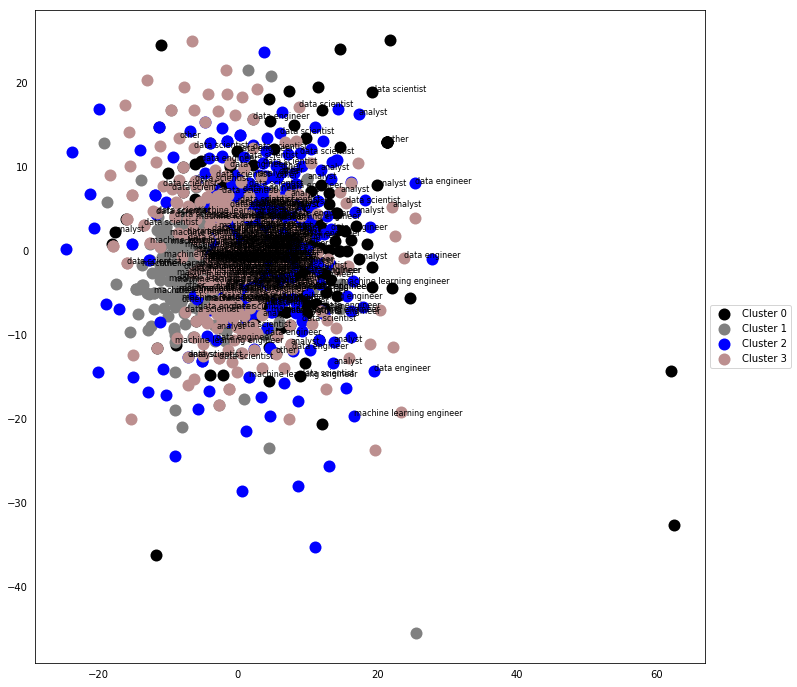

In [12]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=RANDOM_SEED)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(TFIDF_matrix.toarray())  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3'}

#set up cluster names using a dict.  
cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)),TITLE = data['TITLE'])) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

#add label in x,y position with the label as the film title
i=1
while i < (len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['TITLE'], size=8)  
    i+=5  # labeling every 5th data point to help clean up the plot


from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('tsne-document-clusters-tfidf.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

plt.show()
pp.close()

In [13]:
# Hierarchical Cluster Analysis
link = linkage(pos)
fig, ax = plt.subplots(figsize=(15, 20)) # set size
plt.title('Hierarchical Clustering Dendrogram - TFIDF'),
plt.xlabel('Cluster size'),
plt.ylabel('Distance')
ax = dendrogram(link, orientation="right", labels=list(df['TITLE']), 
                p=8, truncate_mode='level');
                
plt.tight_layout() #show plot with tight layout
plt.savefig('hierarchical_clusters-TFIDF.png', dpi=200) #save figure as ward_clusters
plt.close()

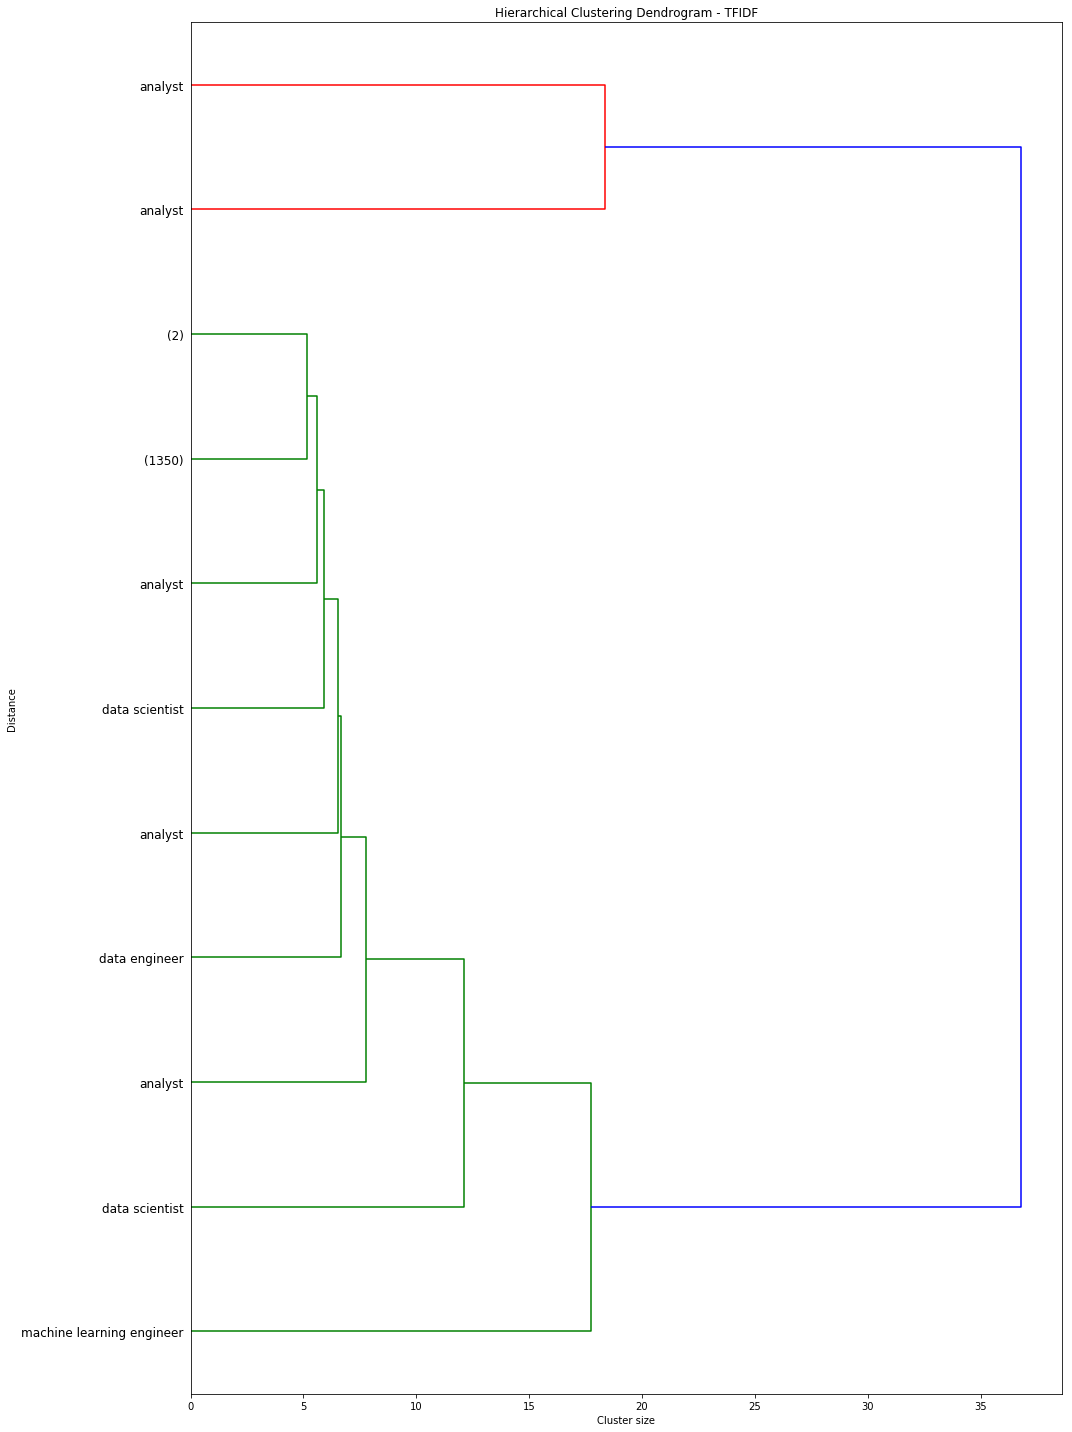

In [14]:
fig

Sklearn TFIDF using analyst judgement matrix

In [15]:
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,1))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix_judgement=Tfidf.fit_transform(processed_text_judgement_combined)     

#creating dataframe from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix_judgement.toarray(), columns=Tfidf.get_feature_names(), index=titles)

dist = 1 - cosine_similarity(TFIDF_matrix_judgement)
print(dist)

# Materialize the sparse data
data_dense = TFIDF_matrix_judgement.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

[[ 0.00000000e+00  8.81194546e-01  9.36460203e-01 ...  9.57121388e-01
   9.71469954e-01  9.58113527e-01]
 [ 8.81194546e-01  2.22044605e-16  9.28025369e-01 ...  9.33388484e-01
   9.41789061e-01  9.53059820e-01]
 [ 9.36460203e-01  9.28025369e-01 -4.44089210e-16 ...  9.37837234e-01
   9.48318549e-01  9.33991716e-01]
 ...
 [ 9.57121388e-01  9.33388484e-01  9.37837234e-01 ...  0.00000000e+00
   9.74717732e-01  9.21666197e-01]
 [ 9.71469954e-01  9.41789061e-01  9.48318549e-01 ...  9.74717732e-01
   0.00000000e+00  9.65320104e-01]
 [ 9.58113527e-01  9.53059820e-01  9.33991716e-01 ...  9.21666197e-01
   9.65320104e-01  1.11022302e-16]]
Sparsicity:  0.8696622734926034 %


In [16]:
print("Top terms using per cluster using uni-grams")
k=2
km = KMeans(n_clusters=k, random_state =RANDOM_SEED)
km.fit(TFIDF_matrix_judgement)
clusters = km.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot_2clusters=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot_2clusters)


km3 = KMeans(n_clusters=3, random_state =RANDOM_SEED)
km3.fit(TFIDF_matrix_judgement)
clusters = km3.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot_3clusters=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot_3clusters)

km4 = KMeans(n_clusters=4, random_state =RANDOM_SEED)
km4.fit(TFIDF_matrix_judgement)
clusters = km4.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot_4clusters=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot_4clusters)

Top terms using per cluster using uni-grams
Cluster                        0      1
TITLE                                  
analyst                      NaN  330.0
data engineer               18.0  243.0
data scientist              82.0  308.0
machine learning engineer  203.0   28.0
other                       83.0   66.0
Cluster                        0      1      2
TITLE                                         
analyst                    259.0   71.0    NaN
data engineer               75.0  182.0    4.0
data scientist             131.0  217.0   42.0
machine learning engineer   19.0   33.0  179.0
other                       53.0   23.0   73.0
Cluster                        0      1      2      3
TITLE                                                
analyst                    186.0   56.0   88.0    NaN
data engineer               43.0   95.0  117.0    6.0
data scientist              71.0  203.0   87.0   29.0
machine learning engineer   15.0   33.0   12.0  171.0
other                  

In [17]:
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(2,2))

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix_judgement=Tfidf.fit_transform(processed_text_judgement_combined)     

#creating dataframe from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix_judgement.toarray(), columns=Tfidf.get_feature_names(), index=titles)

dist = 1 - cosine_similarity(TFIDF_matrix_judgement)
print(dist)

# Materialize the sparse data
data_dense = TFIDF_matrix_judgement.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

[[ 2.99760217e-15  9.94997922e-01  9.92388473e-01 ...  9.96372546e-01
   1.00000000e+00  1.00000000e+00]
 [ 9.94997922e-01  2.22044605e-15  9.98197239e-01 ...  9.98831657e-01
   9.99630984e-01  1.00000000e+00]
 [ 9.92388473e-01  9.98197239e-01 -2.22044605e-15 ...  9.97293043e-01
   9.99225595e-01  1.00000000e+00]
 ...
 [ 9.96372546e-01  9.98831657e-01  9.97293043e-01 ...  3.10862447e-15
   9.99001473e-01  9.93466370e-01]
 [ 1.00000000e+00  9.99630984e-01  9.99225595e-01 ...  9.99001473e-01
  -8.21565038e-15  1.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  9.93466370e-01
   1.00000000e+00  1.15463195e-14]]
Sparsicity:  0.1274536430698842 %


K Means Clustering - TFIDF Analyst Judgement

Now let's try bi-grams

In [18]:
print("Top terms using per cluster using bi-grams")
k=2
km = KMeans(n_clusters=k, random_state =RANDOM_SEED)
km.fit(TFIDF_matrix_judgement)
clusters = km.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot_2clusters=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot_2clusters)


km3 = KMeans(n_clusters=3, random_state =RANDOM_SEED)
km3.fit(TFIDF_matrix_judgement)
clusters = km3.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot_3clusters=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot_3clusters)

km4 = KMeans(n_clusters=4, random_state =RANDOM_SEED)
km4.fit(TFIDF_matrix_judgement)
clusters = km4.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot_4clusters=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot_4clusters)

Top terms using per cluster using bi-grams
Cluster                      0    1
TITLE                              
analyst                      4  326
data engineer               21  240
data scientist             197  193
machine learning engineer  188   43
other                       78   71
Cluster                      0    1    2
TITLE                                   
analyst                    280   48    2
data engineer               56  193   12
data scientist              62  298   30
machine learning engineer    9   57  165
other                       44   47   58
Cluster                      0    1    2    3
TITLE                                        
analyst                    112    4  160   54
data engineer               95   16   92   58
data scientist              32   42  117  199
machine learning engineer    9  166   16   40
other                       20   65   31   33


Top Terms per cluster using unigram

In [19]:
# Refit with 3 clusters.
k=3
km = KMeans(n_clusters=k, random_state =RANDOM_SEED)
km.fit(TFIDF_matrix_judgement)
clusters = km.labels_.tolist()

terms = Tfidf.get_feature_names()
Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': processed_text_judgement}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])
frame=pd.concat([frame,data['TITLE']], axis=1)
frame['record']=1


In [20]:
print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d IDs:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['ID']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

Top terms per cluster:
Cluster 0:
 data analyst
 data analysis
 years experience
 data analytics
 data center
 communication skills
 data management
 business intelligence
 data quality
 bachelors degree
Cluster 0 IDs: 350, 7, 16, 355, 32, 33, 44, 47, 50, 65, 66, 96, 99, 112, 117, 118, 130, 145, 148, 149, 160, 165, 180, 207, 214, 215, 246, 258, 262, 275, 280, 291, 295, 308, 309, 331, 332, 333, 363, 418, 529, 578, 581, 613, 676, 690, 1054, 1052, 1051, 1034, 1049, 1050, 1055, 731, 735, 747, 751, 752, 753, 895, 766, 768, 769, 774, 790, 791, 794, 795, 1012, 1048, 806, 807, 811, 813, 814, 825, 826, 827, 861, 874, 875, 878, 893, 894, 905, 911, 922, 925, 926, 940, 969, 970, 973, 984, 988, 989, 991, 1011, 1026, 1028, 1044, 1045, 1046, 1047, 1383, 1380, 1367, 1378, 1366, 1368, 1379, 1063, 1064, 1065, 1066, 1068, 1069, 1070, 1071, 1072, 1381, 1382, 1357, 1358, 1082, 1083, 1086, 1087, 1088, 1089, 1098, 1099, 1100, 1101, 1103, 1104, 1105, 1106, 1110, 1116, 1117, 1119, 1120, 1121, 1122, 1123, 1127,

Plotting

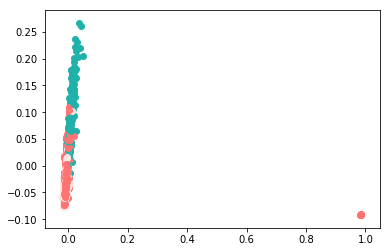

In [21]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

# Let's see how this looks using PCA.
num_clusters = 3
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073',
}
pca_num_components = 2

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)


# print labels
labels = clustering_model.fit_predict(TFIDF_matrix_judgement)

X = TFIDF_matrix_judgement.todense()

reduced_data = PCA(n_components=2).fit_transform(X)
# print reduced_data

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

Note: TSNE algorithm used for multidimensional scaling

C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


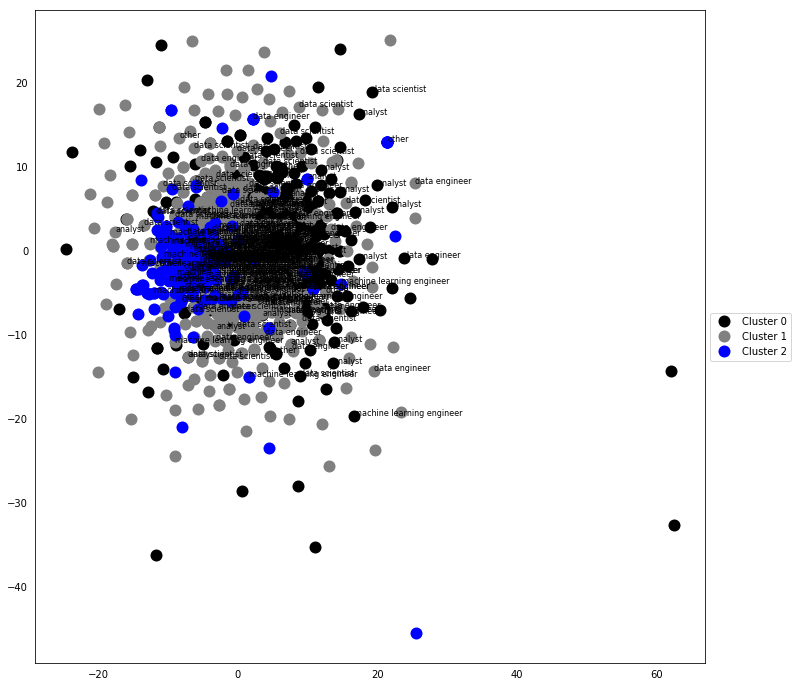

In [22]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=RANDOM_SEED)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(TFIDF_matrix_judgement.toarray())  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3'}

#set up cluster names using a dict.  
cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)),TITLE = data['TITLE'])) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

#add label in x,y position with the label as the film title
i=1
while i < (len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['TITLE'], size=8)  
    i+=5  # labeling every 5th data point to help clean up the plot


from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('tsne-document-clusters-tfidf.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

plt.show()
pp.close()

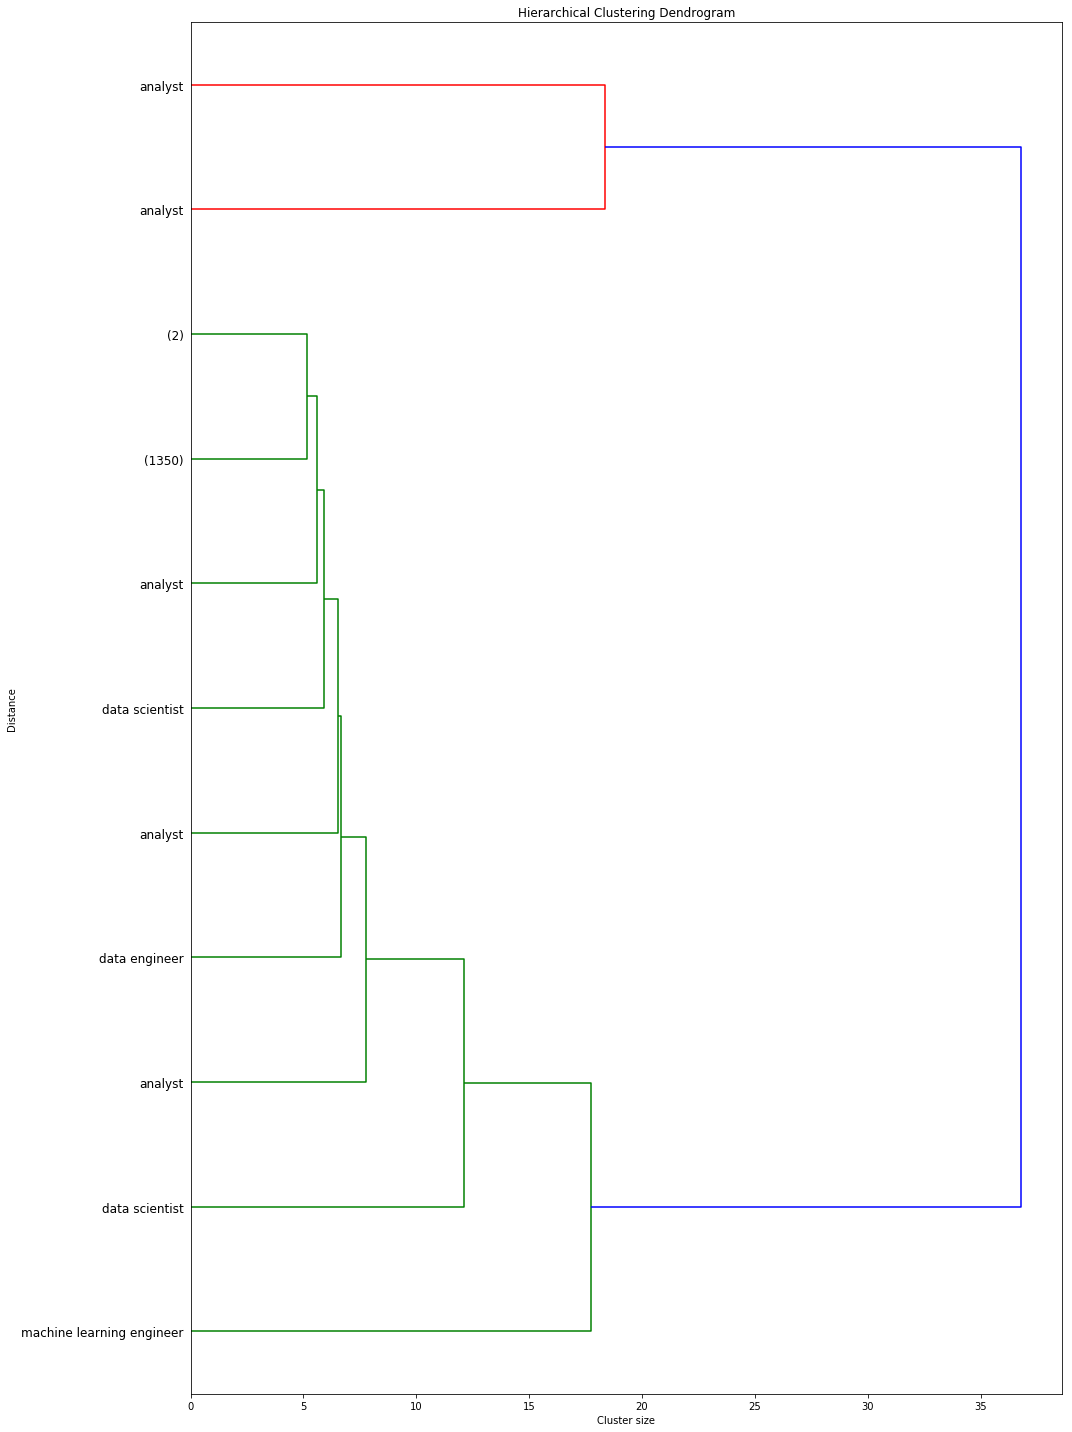

In [23]:
# Hierarchical Cluster Analysis
link1 = linkage(pos)
fig, ax = plt.subplots(figsize=(15, 20)) # set size
plt.title('Hierarchical Clustering Dendrogram'),
plt.xlabel('Cluster size'),
plt.ylabel('Distance')
ax = dendrogram(link1, orientation="right", labels=list(df['TITLE']), 
                p=8, truncate_mode = 'level');
                
plt.tight_layout() #show plot with tight layout
plt.savefig('hierarchical_clusters-analyst-judgement.png', dpi=200) #save figure as ward_clusters

plt.close()
fig

Doc2Vec

In [24]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text_judgement)):
    vector=pd.DataFrame(model.infer_vector(processed_text_judgement[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': data['ID']}
t=pd.DataFrame(doc_titles)

#doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

K Means Clustering - doc2vec

In [25]:
k=2
km = KMeans(n_clusters=k, random_state =RANDOM_SEED)
km.fit(doc2vec_df)
clusters = km.labels_.tolist()


Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot)
# at k=4 we only see two categories: one basically machine learning, the other
# all other titles

km3 = KMeans(n_clusters=3, random_state =RANDOM_SEED)
km3.fit(doc2vec_df)
clusters = km3.labels_.tolist()


Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot3=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot3)

km4 = KMeans(n_clusters=4, random_state =RANDOM_SEED)
km4.fit(doc2vec_df)
clusters = km4.labels_.tolist()


Dictionary={'ID':list(data["ID"]), 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'ID','Text'])


frame=pd.concat([frame,data['TITLE']], axis=1)

frame['record']=1

pivot4=pd.pivot_table(frame, values='record', index='TITLE',
                     columns='Cluster', aggfunc=np.sum)
print(pivot4)

Cluster                      0    1
TITLE                              
analyst                    156  174
data engineer              125  136
data scientist             175  215
machine learning engineer  112  119
other                       68   81
Cluster                      0    1    2
TITLE                                   
analyst                    115  102  113
data engineer               83   91   87
data scientist             120  132  138
machine learning engineer   72   81   78
other                       47   56   46
Cluster                     0    1   2    3
TITLE                                      
analyst                    67   96  73   94
data engineer              53   74  60   74
data scientist             79  120  82  109
machine learning engineer  57   61  51   62
other                      37   40  36   36


Plotting

C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


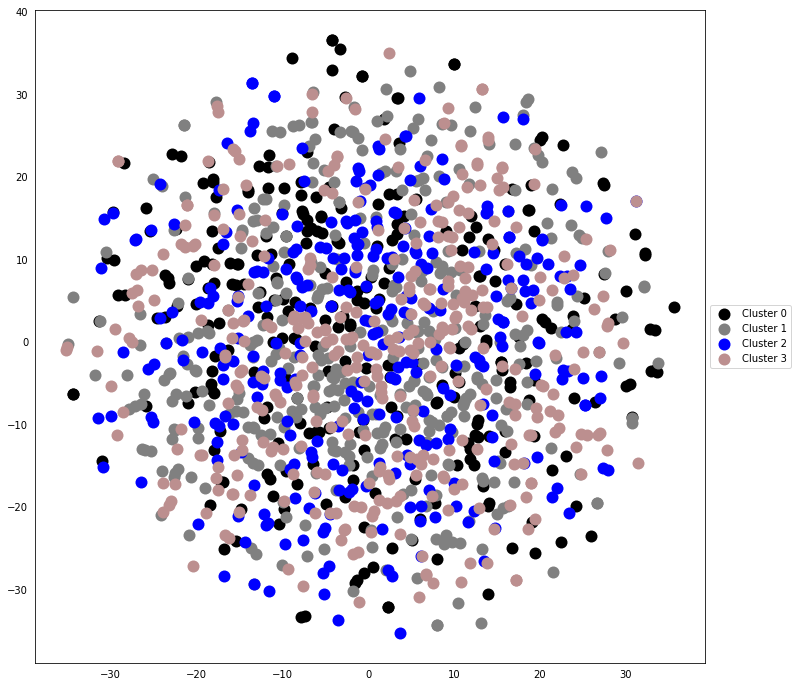

In [26]:
#### Note: TSNE algorithm used for multidimensional scaling
mds = TSNE(n_components=2, metric="euclidean", random_state=RANDOM_SEED)

# Note: The objective here is to obtain a picture of the documents in two dimensions
pos = mds.fit_transform(doc2vec_df)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown'}

#set up cluster names using a dict.  
cluster_labels = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3'}

#set up cluster names using a dict.  
cluster_dict = cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_labels[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #show legend with only 1 point

pp = PdfPages('tsne-document-clusters-doc2vec.pdf')

fig.savefig(pp, format = 'pdf', 
            orientation = 'landscape', pad_inches = 0.5)

pp.close()


We aren't seeing any useful clustering here

Biclustering documents with Spectral Co-Clustering algorithm
Reference https://scikit-learn.org/0.18/auto_examples/bicluster/bicluster_newsgroups.html
This doesn't end up being very insightful for this application

In [27]:
def number_aware_tokenizer(doc):
    """ Tokenizer that maps all numeric tokens to a placeholder.

    For many applications, tokens that begin with a number are not directly
    useful, but the fact that such a token exists can be relevant.  By applying
    this form of dimensionality reduction, some methods may perform better.
    """
    token_pattern = re.compile(u'(?u)\\b\\w\\w+\\b')
    tokens = token_pattern.findall(doc)
    tokens = ["#NUMBER" if token[0] in "0123456789_" else token
              for token in tokens]
    return tokens


y_true = list(data['TITLE'])

cocluster = SpectralCoclustering(n_clusters=len(title_categories),
                                 svd_method='arpack', random_state=0)


print("Vectorizing...")
X = Tfidf.fit_transform(processed_text_judgement_combined)

print("Coclustering...")
start_time = time()
cocluster.fit(X)
y_cocluster = cocluster.row_labels_
print("Done in {:.2f}s. V-measure: {:.4f}".format(
    time() - start_time,
    v_measure_score(y_cocluster, y_true)))

print("MiniBatchKMeans...")
start_time = time()
y_kmeans = km.fit_predict(X)
print("Done in {:.2f}s. V-measure: {:.4f}".format(
    time() - start_time,
    v_measure_score(y_kmeans, y_true)))

feature_names = Tfidf.get_feature_names()
document_names = list(data['ID'])


def bicluster_ncut(i):
    rows, cols = cocluster.get_indices(i)
    if not (np.any(rows) and np.any(cols)):
        import sys
        return sys.float_info.max
    row_complement = np.nonzero(np.logical_not(cocluster.rows_[i]))[0]
    col_complement = np.nonzero(np.logical_not(cocluster.columns_[i]))[0]
    # Note: the following is identical to X[rows[:, np.newaxis], cols].sum() but
    # much faster in scipy <= 0.16
    weight = X[rows][:, cols].sum()
    cut = (X[row_complement][:, cols].sum() +
           X[rows][:, col_complement].sum())
    return cut / weight


def most_common(d):
    """Items of a defaultdict(int) with the highest values.

    Like Counter.most_common in Python >=2.7.
    """
    return sorted(iteritems(d), key=operator.itemgetter(1), reverse=True)


bicluster_ncuts = list(bicluster_ncut(i)
                       for i in range(len(title_categories)))
best_idx = np.argsort(bicluster_ncuts)[:5]

print()
print("Best biclusters:")
print("----------------")
for idx, cluster in enumerate(best_idx):
    n_rows, n_cols = cocluster.get_shape(cluster)
    cluster_docs, cluster_words = cocluster.get_indices(cluster)
    if not len(cluster_docs) or not len(cluster_words):
        continue

    # title_categories
    counter = defaultdict(int)
    for i in cluster_docs:
        counter[document_names[i]] += 1
    cat_string = ", ".join("{:.0f}% {}".format(float(c) / n_rows * 100, name)
                           for name, c in most_common(counter)[:3])

    # words
    out_of_cluster_docs = cocluster.row_labels_ != cluster
    out_of_cluster_docs = np.where(out_of_cluster_docs)[0]
    word_col = X[:, cluster_words]
    word_scores = np.array(word_col[cluster_docs, :].sum(axis=0) -
                           word_col[out_of_cluster_docs, :].sum(axis=0))
    word_scores = word_scores.ravel()
    important_words = list(feature_names[cluster_words[i]]
                           for i in word_scores.argsort()[:-11:-1])

    print("bicluster {} : {} documents, {} words".format(
        idx, n_rows, n_cols))
    print("title_categories   : {}".format(cat_string))
    print("words        : {}\n".format(', '.join(important_words)))



Vectorizing...
Coclustering...
Done in 2.14s. V-measure: 0.0013
MiniBatchKMeans...
Done in 47.47s. V-measure: 0.2051

Best biclusters:
----------------
bicluster 0 : 1360 documents, 197700 words
title_categories   : 0% 354, 0% 353, 0% 335
words        : machine learning, data science, big data, data scientist, computer science, years experience, data engineer, data analyst, experience working, data analysis

bicluster 1 : 1 documents, 249 words
title_categories   : 100% 1341
words        : des systmes, interlocuteurs achats, gestion des, deuros safran, safran est, support pour, avec des, des interlocuteurs, achat safran, groupe sengage



Non-Negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA)

In [28]:
# NMF is able to use tf-idf
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
no_features = 5000
no_topics = 4

# Reference: https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(processed_text_judgement_combined)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(processed_text_judgement_combined)
tf_feature_names = tf_vectorizer.get_feature_names()
no_top_words = 15

In [29]:
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
data team work youll working people role business help experience new technology make company clients
Topic 1:
learning machine experience software algorithms computer deep engineer models research vision science engineering python development
Topic 2:
data big experience engineer years spark aws hadoop cloud etl technologies pipelines kafka scala platform
Topic 3:
data business analysis experience information management reporting skills support analyst statistical reports quality analytics required


In [30]:
# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=20, learning_method='online', learning_offset=10,random_state=0).fit(tf)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
healthcare health research clinical vision processing medical software patients care image scientific patient imaging arm
Topic 1:
data experience learning team work machine business working science skills development new solutions analytics engineering
Topic 2:
games software learning deliver promise innovation knowledge game machine receive retail gaming sainsburys job mobile
Topic 3:
data business experience work support analysis information management skills team analyst working reporting required including


In [31]:
# Log Likelyhood: Higher the better
# Reference: https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

print("Log Likelihood: ", lda.score(tf))


# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=no_topics,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(tf)
print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.5,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=-1, n_topics=4, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tf))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2322372.4733769377


C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=4, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)
Log Likelihood:  -2318753.684537868
Perplexity:  1370.4907849394199
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 4,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [32]:
# Grid Search
# Define Search Param
search_params = {'n_components': [2, 3, 4, 5, 6], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

GridSearchCV(cv=10, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=20,
             mean_change_tol=0.001, n_components=4, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=search_params,
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
#besides num of components, try learning_decay, max_iter, learning_offset (downweigh early iterations. Should be > 1). 
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))
print(model.param_grid)

C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Model's Params:  {'learning_decay': 0.7, 'n_components': 2}
Best Log Likelihood Score:  -797980.9049901032
Model Perplexity:  1381.1557705838566
{'n_components': [2, 3, 4, 5, 6], 'learning_decay': [0.5, 0.7, 0.9]}


C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


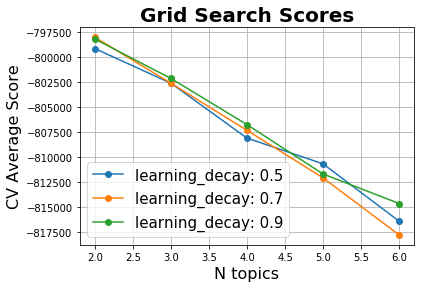

In [33]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [2, 3, 4, 5, 6]
learning_decay = [.5, .7, .9]
# Calling Method 
# Reference: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    ax = plt.figure().gca()
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1,  scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('True')

# Calling Method 
plot_grid_search(model.cv_results_, n_topics, learning_decay, 'N topics', 'learning_decay')

The log likelihood goes down (higher is better) as we add topics. So we aren't seeing 3-4 topics clustering clearly. 

In [34]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf)
# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

print(df_document_topic.head(10))

df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
print(df_topic_distribution)

      Topic0  Topic1  dominant_topic
Doc0    0.57    0.43               0
Doc1    0.32    0.68               1
Doc2    0.90    0.10               0
Doc3    0.92    0.08               0
Doc4    0.95    0.05               0
Doc5    0.76    0.24               0
Doc6    0.56    0.44               0
Doc7    0.05    0.95               1
Doc8    0.98    0.02               0
Doc9    0.92    0.08               0
   Topic Num  Num Documents
0          0            785
1          1            576


In [35]:
#Visualize LDA model with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, tf, tf_vectorizer, mds='tsne')
panel

C:\Users\brenn\Anaconda3\envs\pyScrapy\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  56.346009
1      60.312561 -141.369141       2        1  43.653991, topic_info=     Category          Freq          Term         Total  loglift  logprob
2539  Default   2696.000000      learning   2696.000000  30.0000  30.0000
2665  Default   2123.000000       machine   2123.000000  29.0000  29.0000
1138  Default  11498.000000          data  11498.000000  28.0000  28.0000
2692  Default    978.000000    management    978.000000  27.0000  27.0000
217   Default    490.000000       analyst    490.000000  26.0000  26.0000
3772  Default    544.000000     reporting    544.000000  25.0000  25.0000
583   Default   2617.000000      business   2617.000000  24.0000  24.0000
2290  Default    984.000000   information    984.000000  23.0000  23.0000
4434  Default   1160.000000       support   1160.000000  22.0000  22.0000
3773  Default    431.000000       reports    431.000000  21.0000  21.0000
182   Default    587.000000    algorithms    587.000000  20.0000  20.0000
216   Default   1386.000000      analysis   1386.000000  19.0000  19.0000
4988  Default    709.000000         youll    709.000000  18.0000  18.0000
3574  Default   1002.000000        python   1002.000000  17.0000  17.0000
3788  Default    788.000000      required    788.000000  16.0000  16.0000
3588  Default    669.000000       quality    669.000000  15.0000  15.0000
1643  Default    256.000000         excel    256.000000  14.0000  14.0000
3990  Default   1618.000000       science   1618.000000  13.0000  13.0000
2863  Default    957.000000        models    957.000000  12.0000  12.0000
1177  Default    422.000000          deep    422.000000  11.0000  11.0000
3533  Default    704.000000       provide    704.000000  10.0000  10.0000
4267  Default    837.000000           sql    837.000000   9.0000   9.0000
1613  Default    284.000000           etl    284.000000   8.0000   8.0000
1139  Default    339.000000      database    339.000000   7.0000   7.0000
1414  Default    202.000000        duties    202.000000   6.0000   6.0000
3444  Default    554.000000     processes    554.000000   5.0000   5.0000
3489  Default    493.000000       project    493.000000   4.0000   4.0000
2442  Default    785.000000           job    785.000000   3.0000   3.0000
3996  Default    366.000000    scientists    366.000000   2.0000   2.0000
2816  Default    202.000000     microsoft    202.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
583    Topic2   1672.909591      business   2617.738030   0.3811  -4.4281
216    Topic2    946.504089      analysis   1386.162745   0.4474  -4.9976
1557   Topic2    192.974545    enterprise    223.885904   0.6803  -6.5878
3489   Topic2    378.564079       project    493.242914   0.5643  -5.9140
3533   Topic2    506.859969       provide    704.712370   0.4993  -5.6222
3444   Topic2    413.341119     processes    554.239237   0.5356  -5.8261
4267   Topic2    576.747095           sql    837.564894   0.4558  -5.4930
2442   Topic2    535.825648           job    785.495646   0.4464  -5.5666
3800   Topic2    525.108602  requirements    776.678197   0.4375  -5.5868
3442   Topic2    402.166947       process    554.311887   0.5080  -5.8535
1553   Topic2    341.928712        ensure    449.045468   0.5564  -6.0158
4982   Topic2    762.022691         years   1283.679019   0.3074  -5.2144
220    Topic2    485.122871    analytical    723.615407   0.4290  -5.6660
2376   Topic2    319.124861      internal    414.632681   0.5671  -6.0848
3321   Topic2    408.213782      position    582.908870   0.4726  -5.8386
4153   Topic2    978.013257        skills   1988.307579   0.1194  -4.9649
1683   Topic2   1748.381688    experience   4742.258062  -0.1689  -4.3840
2246   Topic2    600.078462     including   1049.716784   0.2697  -5.4533
4946   Topic2   1149.337287  